In [1]:
# import modules
import pandas as pd 
pd.set_option('display.max_rows', 10)
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from osgeo import gdal
import glob
from tqdm.notebook import tqdm


## calculate area (sqkm) for given slope & distance thresholds using geopandas and rasterstats

0      5.0
1     10.0
2     15.0
3     20.0
4     25.0
      ... 
9     50.0
10    55.0
11    60.0
12    65.0
13    70.0
Name: radii, Length: 14, dtype: float64
    Name      long      lat                         geometry  \
0  Taupo  176.0704 -38.6843  POINT (1867076.976 5713780.848)   

                                               5.0km  \
0  POLYGON ((1872076.976 5713780.848, 1872052.899...   

                                              10.0km  \
0  POLYGON ((1877076.976 5713780.848, 1877028.823...   

                                              15.0km  \
0  POLYGON ((1882076.976 5713780.848, 1882004.747...   

                                              20.0km  \
0  POLYGON ((1887076.976 5713780.848, 1886980.670...   

                                              25.0km  \
0  POLYGON ((1892076.976 5713780.848, 1891956.594...   

                                              30.0km  \
0  POLYGON ((1897076.976 5713780.848, 1896932.517...   

                                

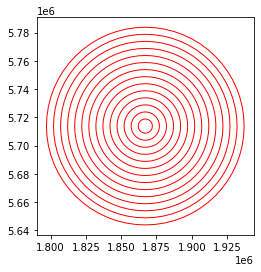

In [2]:
# define function to generate buffers for each FUA
def genBuffers(FUAs, distance_thresholds):
    # import csv containing lat/long for FUAs and create points gpd
    fua_df = pd.read_csv(FUAs)
    fua_gdf = gpd.GeoDataFrame(fua_df, geometry=gpd.points_from_xy(fua_df.long, fua_df.lat), crs='EPSG:4326').to_crs(2193)
    # import thresholds and select radii 
    distances = pd.read_csv(distance_thresholds)
    radii = distances.radii.dropna()
    # buffer each FUA by distance thresholds and add to fua_gdf
    for value in radii:
        # convert value to metres
        value_m = value * 1000 
        fua_gdf[str(value) + 'km'] = fua_gdf.buffer(value_m)
    
    return fua_gdf

# track time
import time
start = time.time()
last = time.time()

# 
fua_distance_thresholds = genBuffers('inputs/FUA-test.csv', 'inputs/thresholds.csv')

print('distance thresholds generated')
print(time.time() - last, 'seconds')
last = time.time()
print()

# check processing by plotting threshold buffers
fig, ax = plt.subplots()
for distance in fua_distance_thresholds.loc[:, [x for x in fua_distance_thresholds.columns if x.endswith('km')]]:
    fua_distance_thresholds[distance].plot(ax=ax, color='None', edgecolor='red')
plt.show()

##calculate area

In [3]:
### DEFINE FUNCTIONS REQUIRED ###
# define function to return pixel counts within geopandas polygon with rasterstats
def calc_pxl_count(geometry, img):
    sum  = zonal_stats(geometry, img, categorical=True)[0]
    return sum

# define function to sum slope values under given threshold and calculate area in sqkm
def calc_area(pxl_count, slope_threshold, pixel_area):
    count = 0
    for key, value in pxl_count.items():
        if key <= slope_threshold:
            count += value 
    area = count * pixel_area
    return area

# function to get pixel size from slope image and return area in sqkm per pixel
def get_pxl_size(img):
    raster = gdal.Open(img)
    gt = raster.GetGeoTransform()
    pxl_size = gt[1]
    area = pxl_size * pxl_size / 1000000
    return area

# define function to calulate developable land area for each FUA
def calc_developable_land_area(slope_imgs_folder, fua_distance_gdf, thresholds_csv):
    last = time.time()
    # create empty dict to store values
    developable_land_dict = {}
    # create list of regions to iterate over from gdf
    regions = fua_distance_gdf['Name'].tolist()
    print(regions)
    # import thresholds and select slope thresholds 
    thresholds = pd.read_csv(thresholds_csv)
    slope_vals = thresholds.slope.dropna()
    #print(slope_vals)
    # iterate over FUA and select corresponding slope image
    for aoi in tqdm(regions, desc='FUAs'):
        data = fua_distance_gdf[fua_distance_gdf['Name'].isin([aoi])]
        #print(data)
        image = glob.glob(slope_imgs_folder + aoi + '-slope.kea')
        #print(image)
        # get pixel size
        pixel_area = get_pxl_size(image[0])
        # add FUA to dict
        fua_dict = developable_land_dict[aoi] = {}
        # iterate over distance thresholds for aoi to calculate pixel counts
        for distance in tqdm(data.loc[:, [x for x in data.columns if x.endswith('km')]], desc='Calc pixel counts'):
            #print(distance)
            #data = data.set_geometry(distance)
            #print(type(data.geometry[0]))
            pxl_sum = calc_pxl_count(data[distance], image[0])
            #print(len(pxl_sum))
            # iterate over slope thresholds calculating area under each threshold and add to aoi_dict
            for value in tqdm(slope_vals, desc='calc area', leave=False):
                #print(value)
                area_value = calc_area(pxl_sum, value, pixel_area)
                # add distance and slope threshold key to dict
                fua_dict['u' + distance + '_u' + str(value) + 'deg'] = area_value
        print('area under thresholds calculated for: ' + aoi)
        print(time.time() - last, 'seconds')
        print() 
    print()
    print('Total processing time')
    print(time.time() - last, 'seconds')
    last = time.time()
    print() 
    return developable_land_dict

In [4]:
### run script and reshape dict to pd.df and write to csv ###

output = calc_developable_land_area('outputs/slope_images/', fua_distance_thresholds, 'inputs/thresholds.csv')

# reshape dict to pd.Dataframe and write to csv
output_df = pd.DataFrame.from_dict(output, orient='columns')
output_df.to_csv('outputs/area-under-slope-distance-thresholds.csv')

['Taupo']


FUAs:   0%|          | 0/1 [00:00<?, ?it/s]

Calc pixel counts:   0%|          | 0/1 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

calc area:   0%|          | 0/19 [00:00<?, ?it/s]

area under thresholds calculated for: Taupo
681.9760119915009 seconds

Total processing time
681.9768598079681 seconds

